# Video Game Sales Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

### Inspect Data - Explore How to Manage Missing Values

In [2]:
# Read in data
games_df = pd.read_csv('./data/Video_Games_Sales_as_at_22_Dec_2016.csv')

In [3]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [4]:
#I want to predict 'Global_Sales' and this looks like a sum of all other sales.  Therefore, I will drop remove those columns
games_df.drop(columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], inplace = True)

In [5]:
games_df['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

**Year_of_Release, Developer, and Publisher** -- If I had more time, I could research the span of years each platform was active and make a dictionary of dictionaries to fill Year_of_Release NaNs or even look up each game, but for now I think I will just assume the average. 

**Scores, Counts, and Ratings** -- I will assume the average of these as well.

In [6]:
# Issue where some of the User_Score entries are 'tbd' and not an actual score
# Will set as NaNs and let the SimpleImputer take care of it
games_df[games_df['User_Score'] == 'tbd']

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
119,Zumba Fitness,Wii,2010.0,Sports,505 Games,6.71,NaN,NaN,tbd,NaN,"Pipeworks Software, Inc.",E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,Namco Bandai Games,3.98,61.0,21.0,tbd,NaN,Digital Eclipse,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,Majesco Entertainment,2.81,NaN,NaN,tbd,NaN,"Majesco Games, Majesco",T
645,uDraw Studio,Wii,2010.0,Misc,THQ,2.42,71.0,9.0,tbd,NaN,THQ,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,Konami Digital Entertainment,2.39,73.0,4.0,tbd,NaN,Konami Computer Entertainment Hawaii,E
...,...,...,...,...,...,...,...,...,...,...,...,...
16699,Planet Monsters,GBA,2001.0,Action,Titus,0.01,67.0,9.0,tbd,NaN,Planet Interactive,E
16701,Bust-A-Move 3000,GC,2003.0,Puzzle,Ubisoft,0.01,53.0,4.0,tbd,NaN,Taito Corporation,E
16702,Mega Brain Boost,DS,2008.0,Puzzle,Majesco Entertainment,0.01,48.0,10.0,tbd,NaN,Interchannel-Holon,E
16708,Plushees,DS,2008.0,Simulation,Destineer,0.01,NaN,NaN,tbd,NaN,Big John Games,E


In [7]:
games_df['User_Score'].replace('tbd', np.nan, inplace=True)

In [8]:
games_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### Transform Data

In [9]:
#Train/Test/Split Data First
features = ['Platform',
            'Year_of_Release',
            'Genre',
            'Publisher',
            'Critic_Score',
            'Critic_Count',
            'User_Score',
            'User_Count',
            'Developer',
            'Rating'
           ]

In [10]:
X = games_df[features]
y = games_df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [11]:
categories = ['Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Developer', 'Rating']
numeric = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']

In [12]:
# This didn't work - says PS3 couldn't convert string to float

#si = SimpleImputer(strategy = 'most_frequent').set_output(transform = 'pandas')

#ctx = ColumnTransformer([
    #('impute_num', SimpleImputer(strategy='mean').set_output(transform = 'pandas'), numeric),
    #('sc_num', StandardScaler(), numeric),
    #('impute_cat', SimpleImputer(strategy='most_frequent').set_output(transform = 'pandas'), categories),
    #('ohe_cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categories)
#], verbose_feature_names_out=False)


This was the most frustrating/enlightening part of the hackathon for me:

[Column Transformer with Mixed Types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [13]:
# number transformer - In hindsight mayber I didn't need this because all of the columns needed transforming, but it's good to know
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#category transformer
categories_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
ctx = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categories_transformer, categories)
    ]
)

In [14]:
pipe = Pipeline([
    ('ctx', ctx),
    ('lr', LinearRegression())
])
    

In [15]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ctx',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Critic_Score',
                                                   'Critic_Count', 'User_Score',
                                                   'User_Count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Platform',
                                                   'Year_of_Release', 'Genre',
                                                   'Publisher', 'Developer',
                                                   'Rating'])])),
                ('lr', LinearRegression())])

In [16]:
print(f'Train R2 value is {round(pipe.score(X_train, y_train),3)}')
print(f'Test R2 value is {round(pipe.score(X_test, y_test),3)}')
print(f'Cross validation cross scores are {cross_val_score(pipe, X_test, y_test)}')

Train R2 value is 0.385
Test R2 value is 0.185
Cross validation cross scores are [ 0.30814233 -0.23850318  0.18625258  0.21361895 -0.44978613]


In [17]:
print(f'Root Mean Squared Error of Training Data: {mean_squared_error(pipe.predict(X_train), y_train, squared = False)}')
print(f'Root Mean Squared Error of Test Data: {mean_squared_error(pipe.predict(X_test), y_test, squared = False)}')

Root Mean Squared Error of Training Data: 1.1167601161158034
Root Mean Squared Error of Test Data: 1.6887897337840105


#### LINE Assumption Plots - Time is a factor, so that assumption is already broken

#### Train

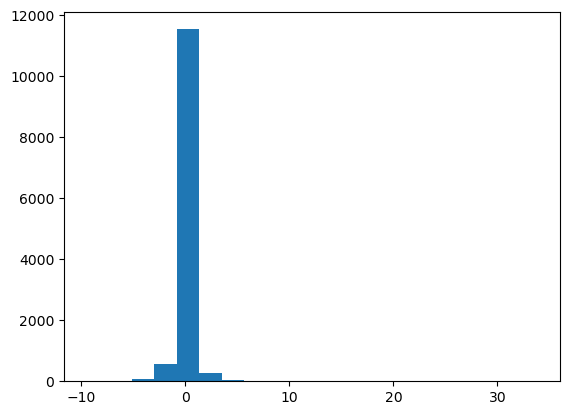

In [18]:
train_preds = pipe.predict(X_train) 
train_resids = y_train - train_preds

plt.hist(train_resids, bins = 20);

#### Test

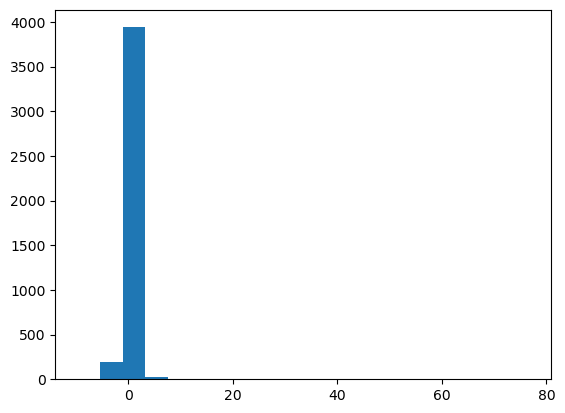

In [19]:
test_preds = pipe.predict(X_test)
test_resids = y_test - test_preds

plt.hist(test_resids, bins = 20);

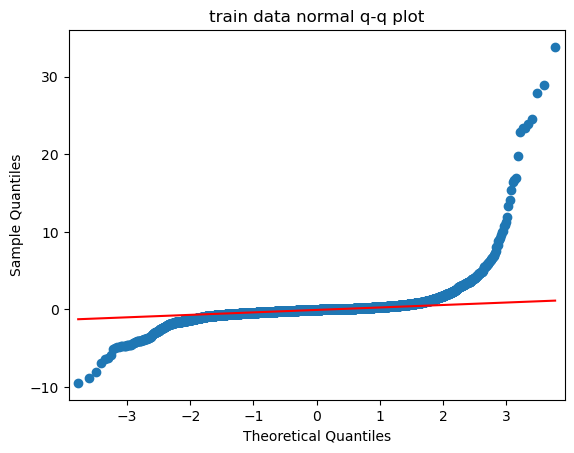

In [20]:
sm.qqplot(train_resids,
         dist= stats.norm,
         line= 'q',)
plt.title('train data normal q-q plot');

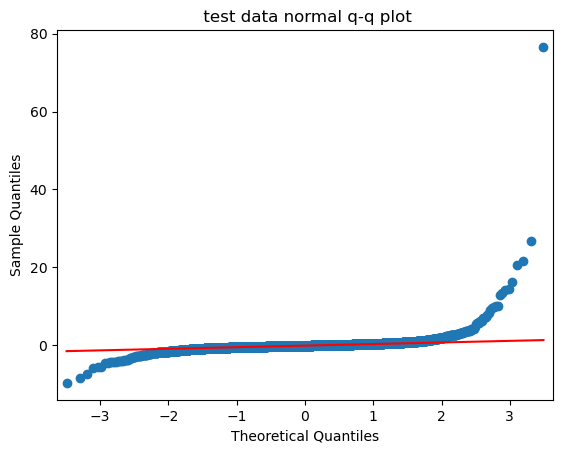

In [21]:
sm.qqplot(test_resids,
         dist= stats.norm,
         line= 'q')
plt.title(' test data normal q-q plot');

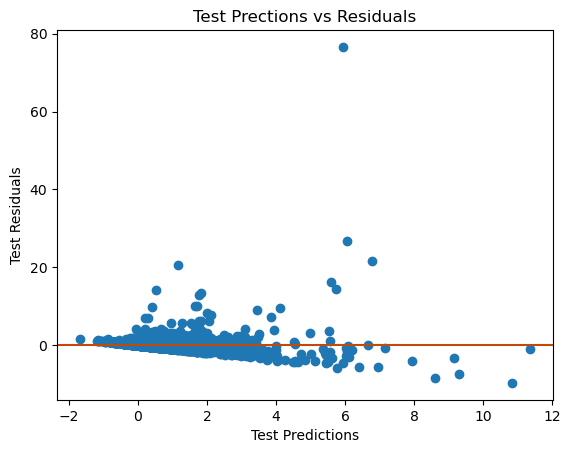

In [22]:
plt.scatter(test_preds, test_resids)
plt.axhline(0, color = 'xkcd:brick orange')
plt.xlabel('Test Predictions')
plt.ylabel('Test Residuals')
plt.title('Test Prections vs Residuals');

No variance here!


### Ridge Regression

In [23]:
# Setting up a list of ridge alphas to check 
alphas = np.linspace(0.1, 10, 1000)

#Cross validation
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

In [24]:
pipe_ridge = Pipeline([
    ('ctx', ctx),
    ('ridge', RidgeCV())
])
 

In [25]:
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('ctx',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Critic_Score',
                                                   'Critic_Count', 'User_Score',
                                                   'User_Count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Platform',
                                                   'Year_of_Release', 'Genre',
                                                   'Publisher', 'Developer',
                                                   'Rating'])])),
                ('ridge', RidgeCV())])

In [26]:
print(f'Train R2 value is {round(pipe_ridge.score(X_train, y_train),3)}')
print(f'Test R2 value is {round(pipe_ridge.score(X_test, y_test),3)}')
print(f'Cross validation cross scores are {cross_val_score(pipe, X_test, y_test)}')

Train R2 value is 0.378
Test R2 value is 0.194
Cross validation cross scores are [ 0.30814233 -0.23850318  0.18625258  0.21361895 -0.44978613]


In [27]:
print(f'Root Mean Squared Error of Training Data: {mean_squared_error(pipe_ridge.predict(X_train), y_train, squared = False)}')
print(f'Root Mean Squared Error of Test Data: {mean_squared_error(pipe_ridge.predict(X_test), y_test, squared = False)}')

Root Mean Squared Error of Training Data: 1.1230721613696368
Root Mean Squared Error of Test Data: 1.6790219352417743


### Lasso Regression

In [28]:
#Lasso alphas to check
l_alphas = np.linspace(1, 3, 1000)

#Cross validation
lasso_cv = LassoCV(alphas = l_alphas)

In [29]:
pipe_lasso = Pipeline([
    ('ctx', ctx),
    ('lasso', LassoCV())
])

In [30]:
pipe_lasso.fit(X_train, y_train)

Pipeline(steps=[('ctx',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Critic_Score',
                                                   'Critic_Count', 'User_Score',
                                                   'User_Count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Platform',
                                                   'Year_of_Release', 'Genre',
                                                   'Publisher', 'Developer',
                                                   'Rating'])])),
                ('lasso', LassoCV())])

In [31]:
print(f'Train R2 value is {round(pipe_lasso.score(X_train, y_train),3)}')
print(f'Test R2 value is {round(pipe_lasso.score(X_test, y_test),3)}')
print(f'Cross validation cross scores are {cross_val_score(pipe, X_test, y_test)}')

Train R2 value is 0.328
Test R2 value is 0.192
Cross validation cross scores are [ 0.30814233 -0.23850318  0.18625258  0.21361895 -0.44978613]


In [32]:
print(f'Root Mean Squared Error of Training Data: {mean_squared_error(pipe_lasso.predict(X_train), y_train, squared = False)}')
print(f'Root Mean Squared Error of Test Data: {mean_squared_error(pipe_lasso.predict(X_test), y_test, squared = False)}')

Root Mean Squared Error of Training Data: 1.1671024075260836
Root Mean Squared Error of Test Data: 1.6820428190598093


### What About Just Platform & Genre?

In [33]:
games_df['Global_Sales'].mean()

0.5335426759973684

In [34]:
X = games_df[['Platform', 'Genre']]
y = games_df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [35]:
games_df.dropna(subset=['Genre'], inplace=True)

In [36]:
ohe_2 = OneHotEncoder(handle_unknown='ignore')

In [37]:
X_train_enc = ohe_2.fit_transform(X_train)
X_test_enc = ohe_2.transform(X_test)

In [38]:
lr = LinearRegression()

In [39]:
lr.fit(X_train_enc, y_train)

LinearRegression()

In [40]:
print(f'Train R2 value is {round(lr.score(X_train_enc, y_train),3)}')
print(f'Test R2 value is {round(lr.score(X_test_enc, y_test),3)}')
print(f'Cross validation cross scores are {cross_val_score(lr, X_test_enc, y_test)}')

Train R2 value is 0.061
Test R2 value is 0.013
Cross validation cross scores are [0.00586662 0.00030956 0.02360604 0.00881867 0.00458169]


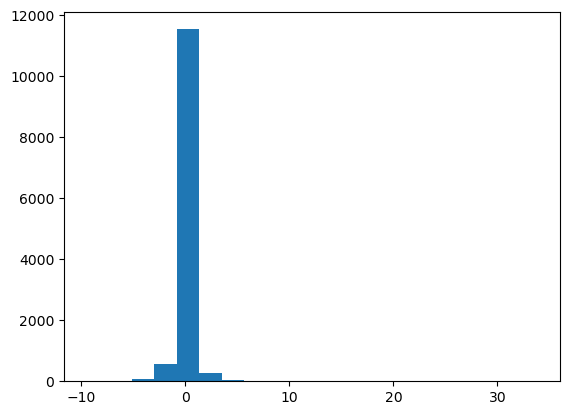

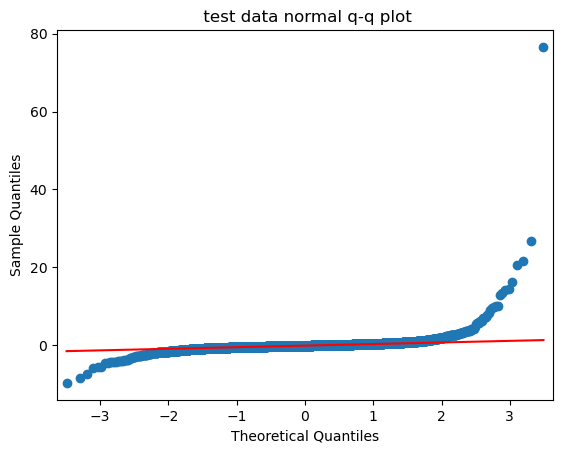

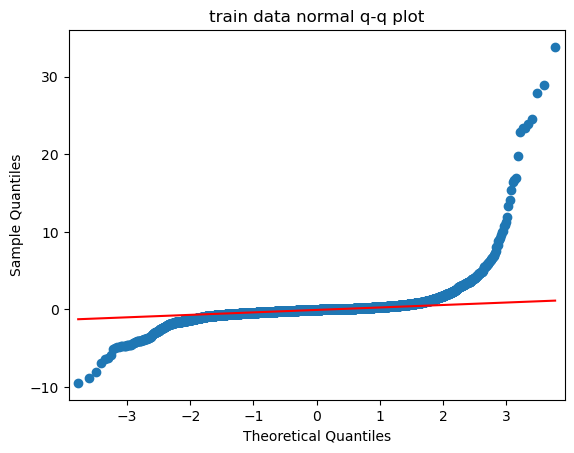

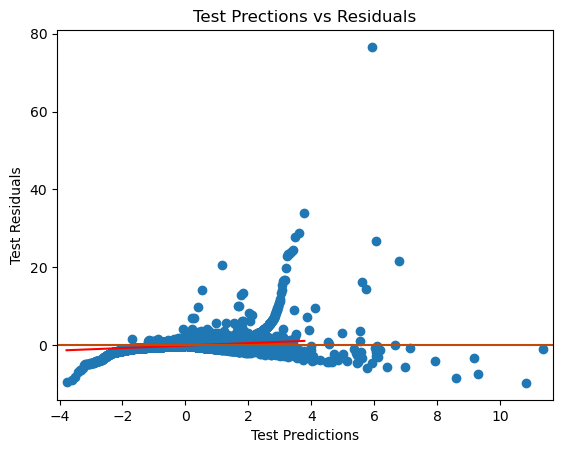

In [41]:
train_preds = lr.predict(X_train_enc)

plt.hist(train_resids, bins = 20);


sm.qqplot(test_resids,
         dist= stats.norm,
         line= 'q')
plt.title(' test data normal q-q plot');


sm.qqplot(train_resids,
         dist= stats.norm,
         line= 'q',)
plt.title('train data normal q-q plot');


sm.qqplot(train_resids,
         dist= stats.norm,
         line= 'q',)
plt.title('train data normal q-q plot');

plt.scatter(test_preds, test_resids)
plt.axhline(0, color = 'xkcd:brick orange')
plt.xlabel('Test Predictions')
plt.ylabel('Test Residuals')
plt.title('Test Prections vs Residuals');